In [2]:
import numpy as np
import json
from pathlib import Path
import shutil
from collections import defaultdict

import matplotlib.pyplot as plt


In [37]:
base_dir = Path("./")
histogram = defaultdict(lambda: defaultdict(lambda: 0))
total_datapoint = 0
for scenario_dir in base_dir.iterdir():
    if not scenario_dir.is_dir() or "scenario" not in scenario_dir.name:
        continue
    # print(scenario_dir.as_posix())
    scenario_name = scenario_dir.name
    for data_file in scenario_dir.glob("onlyq_*.json"):
        tr_or_ts = data_file.name.split("_")[1].split(".")[0]
        # repr = f"{scenario_name}_{tr_or_ts}"
        # repr = tr_or_ts
        # histogram[repr] = defaultdict(lambda: 0)
        with open(data_file, "r", encoding="utf-8") as f:
            datas = json.load(f)
            for data in datas:
                input = data["Input"]
                tags = data["Tags"]
                styles, returns = tags["Style"], tags["Returns"]
                type = styles["Type"]
                temporal = styles["Temporal"]
                spatials = styles["Spatials"]
                processing = styles["Processing"]
                modalites = styles["Modality"]

                # print(type, temporal, spatials, processing, modalites)

                query = []

                if any(ret in ["Spatial"] for ret in returns):
                    query.append("Spatial")
                if "Dates" in returns:
                    query.append("Temporal")
                if any(ret in ["Temp", "Energy", "Humidity"] for ret in returns):
                    query.append("Value")
                
                if any(spatial in ["화성", "1층", "뒷반", "롯데캐슬"] for spatial in spatials):
                    type.append("Unknown")
                
                if any(modality in ["습도", "에너지 사용량"] for modality in modalites):
                    type.append("Unknown")
                
                if "10년" in temporal:
                    type.append("Unknown")
                
                has_implicit = any(t in ["Implicit modality", "Implicit spatial", "Implicit temporal"] for t in type)
                if has_implicit:
                    type = [t for t in type if t not in ["Implicit modality", "Implicit spatial", "Implicit temporal"]]
                    type.append("Implicit conditions")

                has_implicit_ops = any(t in ["Implicit operations"] for t in type)
                if has_implicit_ops:
                    type = [t for t in type if t not in ["Implicit operations"]]
                    type.append("Implicit operations")

                if type == [] or type == [""]:
                    type = ["Basic"]

                ops = []
                if processing == ["Get"]:
                    ops.append("Simple get")
                
                if any(operation in ["Avg", "Diff", "Min", "Max"] for operation in processing):
                    ops.append("Supported")
                
                if any(operation in ["ArgMin", "ArgMax"] for operation in processing):
                    ops.append("Unsupported")
                
                for t in type:
                    histogram["Type"][t] += 1
                
                for op in ops:
                    histogram["Ops"][op] += 1
                
                for q in query:
                    histogram["Query"][q] += 1
                
                # # print(input, style)
                # for style in styles:
                #     histogram[repr][style] += 1


In [35]:
# apply round(x * 8/5) to all values in histogram
for repr, hist in histogram.items():
    for key, value in hist.items():
        hist[key] = round(value * 8/5)


In [38]:
# for repr, hist in histogram.items():
#     print(f"{repr}: {hist}")

# Python dictionary format for copy-paste
print("\n# Copy-paste ready Python code:")
print("histogram = {")
for repr, hist in histogram.items():
    print(f"    '{repr}': {{")
    for key, value in hist.items():
        print(f"        '{key}': {value},")
    print("    },")
print("}")



# Copy-paste ready Python code:
histogram = {
    'Type': {
        'Implicit operations': 9,
        'Implicit conditions': 28,
        'Basic': 9,
        'Unknown': 8,
    },
    'Ops': {
        'Supported': 20,
        'Unsupported': 12,
        'Simple get': 9,
    },
    'Query': {
        'Value': 27,
        'Temporal': 9,
        'Spatial': 3,
    },
}


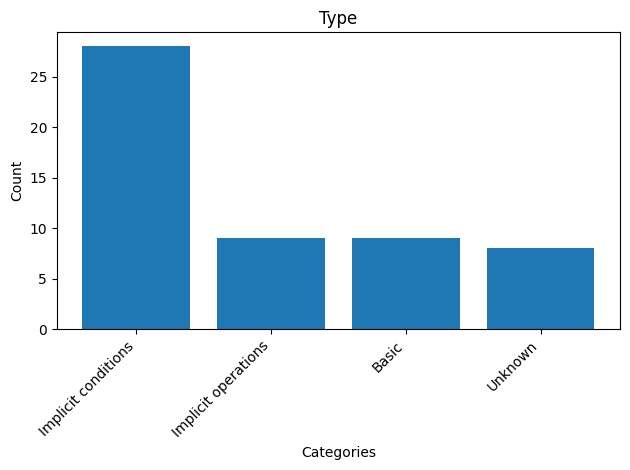

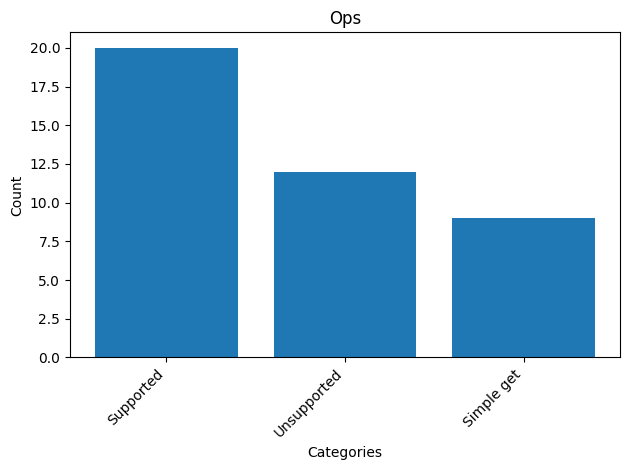

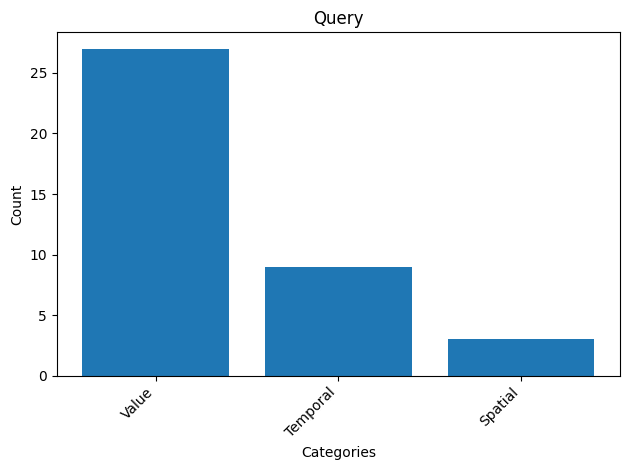

In [33]:
for repr, hist in histogram.items():
    hist = dict(sorted(hist.items(), key=lambda x: x[1], reverse=True))
    labels = list(hist.keys())
    sizes = list(hist.values())
    fig1, ax1 = plt.subplots()
    ax1.bar(labels, sizes)
    ax1.set_xlabel('Categories')
    ax1.set_ylabel('Count')
    plt.title(f"{repr}")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    plt.close()

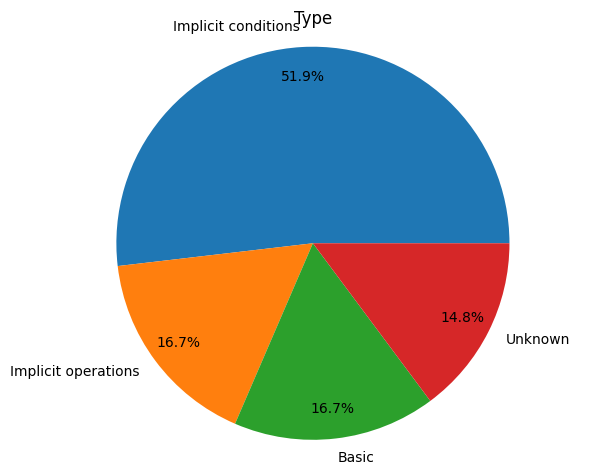

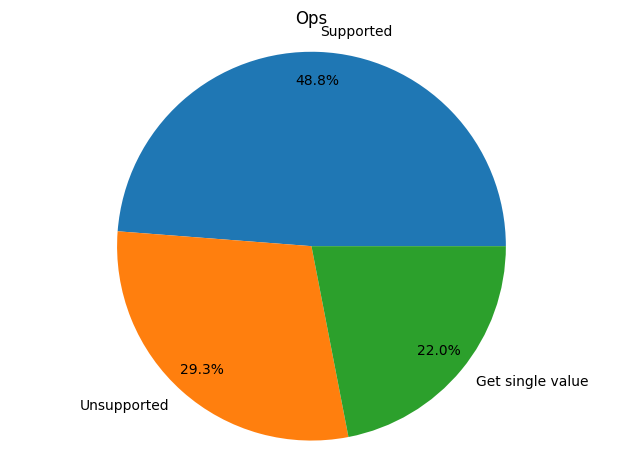

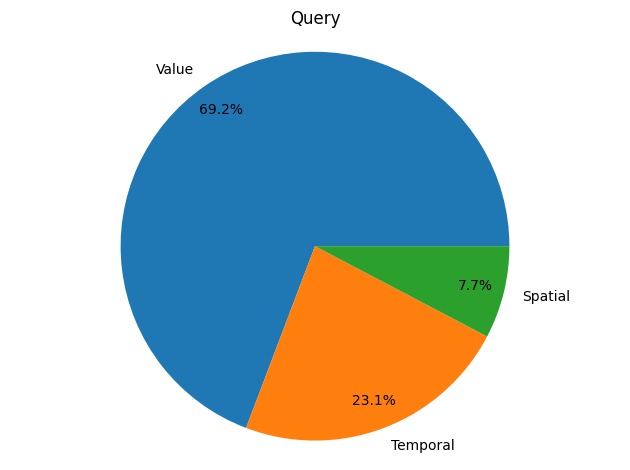

In [ ]:

# pie chart
# sort by number of styles

for repr, hist in histogram.items():
    hist = dict(sorted(hist.items(), key=lambda x: x[1], reverse=True))
    labels = hist.keys()
    sizes = hist.values()
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, 
    autopct='%1.1f%%', startangle=0, 
        pctdistance=0.85, labeldistance=1.1)
    ax1.axis('equal')
    plt.title(f"{repr}")
    plt.tight_layout()
    plt.show()
    plt.close()

In [ ]:
histogram_cat = defaultdict(lambda: 0)
for key, value in histogram.items():
    for style, count in value.items():
        histogram_cat[style] += count

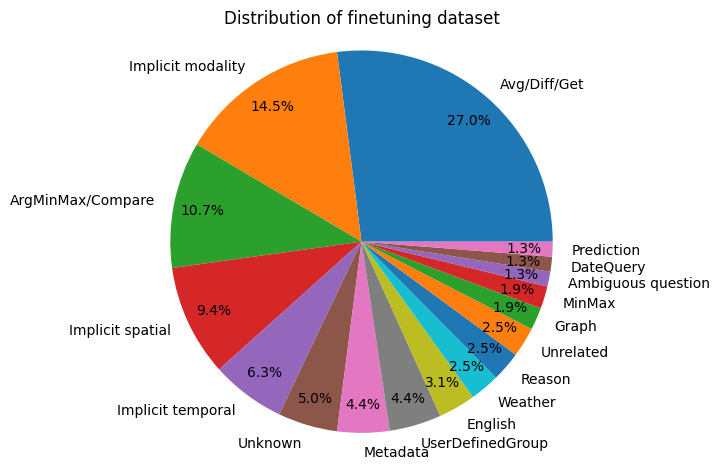

In [10]:
import matplotlib.pyplot as plt

# pie chart
# sort by number of styles

histogram_cat = dict(sorted(histogram_cat.items(), key=lambda x: x[1], reverse=True))
labels, sizes = zip(*histogram_cat.items())
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, 
autopct='%1.1f%%', startangle=0, 
    pctdistance=0.85, labeldistance=1.1)
ax1.axis('equal')
plt.title(f"Distribution of finetuning dataset")
plt.tight_layout()
plt.show()
plt.close()


In [11]:
print(list(histogram_cat.keys()))

['Avg/Diff/Get', 'Implicit modality', 'ArgMinMax/Compare', 'Implicit spatial', 'Implicit temporal', 'Unknown', 'Metadata', 'UserDefinedGroup', 'English', 'Weather', 'Reason', 'Unrelated', 'Graph', 'MinMax', 'Ambiguous question', 'DateQuery', 'Prediction']


In [ ]:
#['Avg/Diff/Get', 'Implicit modality', 'ArgMinMax/Compare', 'Implicit spatial', 'Implicit temporal', 'Unknown', 'Metadata', 'UserDefinedGroup', 'English', 'Weather', 'Reason', 'Unrelated', 'Graph', 'MinMax', 'Ambiguous question', 'DateQuery', 'Prediction'

key_map = {
    "Implicit": ["Implicit modality", "Implicit spatial", "Implicit temporal", "Weather"],
    "Get": ["Avg/Diff/Get"],
    "Compare": ["ArgMinMax/Compare", "MinMax"],
    "CornerCase": ["Unknown", "Unrelated", "Prediction"],
    "Metadata": ["Metadata", "UserDefinedGroup", "DateQuery"],
    "Reason": ["Reason"],
    "Graph": ["Graph"],
}

In [ ]:
import matplotlib.pyplot as plt

# pie chart
# sort by number of styles

histogram_cat = dict(sorted(histogram_cat.items(), key=lambda x: x[1], reverse=True))
labels, sizes = zip(*histogram_cat.items())
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, 
autopct='%1.1f%%', startangle=0, 
    pctdistance=0.85, labeldistance=1.1)
ax1.axis('equal')
plt.title(f"Distribution of finetuning dataset")
plt.tight_layout()
plt.show()
plt.close()
